In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split

from cluster_experiments.random_splitter import NonClusteredSplitter
from cluster_experiments.perturbator import NormalPerturbator
from cluster_experiments.experiment_analysis import OLSAnalysis

In [22]:
treatment_effect = 0.0
total_panel = 10
np.array([treatment_effect*np.exp(-treatment_effect*i) for i in range(total_panel)])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
mymat = np.random.randint(-10, 10, size=(10, 15))
my_add = np.arange(1, 16)
print(mymat)
print('*')
mymat + my_add
print(mymat + my_add)

[[ -5  -2  -1  -4   2  -3 -10  -6  -3   2  -4  -5   2   6  -7]
 [  5   4  -4  -5  -7   2   7   0   4   5  -9  -2   7   7   4]
 [ -7   2  -3  -3   4   4  -5  -6   9  -4  -9  -5   4   2   3]
 [  6   1   5  -3   6   5   1   2   3  -8   2   0  -4   7  -3]
 [  3   5  -2   5   6   3  -3  -6   4   8  -8  -1   3   0  -3]
 [ -6  -8   8  -1  -1  -9   4   6   0   8   7  -7  -2   1  -6]
 [  5  -2   0   3  -4   2  -7   1  -4  -3  -4  -9  -3   0   3]
 [ -7  -1  -6   4   0   6  -4  -1  -4  -3  -6  -7   4  -2   6]
 [  7   3  -7  -2   4  -7  -4  -7  -5   9   4  -5   7   3  -7]
 [  6   2  -8   0   5  -1  -1  -5  -1 -10  -3  -5   2  -2  -6]]
*
[[-4  0  2  0  7  3 -3  2  6 12  7  7 15 20  8]
 [ 6  6 -1 -1 -2  8 14  8 13 15  2 10 20 21 19]
 [-6  4  0  1  9 10  2  2 18  6  2  7 17 16 18]
 [ 7  3  8  1 11 11  8 10 12  2 13 12  9 21 12]
 [ 4  7  1  9 11  9  4  2 13 18  3 11 16 14 12]
 [-5 -6 11  3  4 -3 11 14  9 18 18  5 11 15  9]
 [ 6  0  3  7  1  8  0  9  5  7  7  3 10 14 18]
 [-6  1 -3  8  5 12  3  7  5  7

In [2]:
class DataGenerator:
    def __init__(
        self,
        target_normal_params = {'loc': 0, 'scale': 1},
        treatment_effect: float = 0.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.target_normal_params = target_normal_params
        self.treatment_effect = treatment_effect
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-treatment_effect*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.clip(np.random.normal(size=(n_samples, self.total_panel), **self.target_normal_params), a_min=0, a_max=np.inf)
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [3]:

def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        treatment_effect = 0.0
    ) -> tuple[float, list[float]]:
    control_data = (
        DataGenerator(
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    treatment_data = (
        DataGenerator(
            treatment_effect=treatment_effect,
            control_group=False
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )

    experiment_data = pd.concat([control_data, treatment_data])

    train_data, test_data = train_test_split(experiment_data, test_size=0.5)

    observed_experiment_analysis = (
        smf.ols(
            formula = 'unit_total ~ 1 + treatment',
            data = test_data
        )
        .fit()
    )
    observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

    predicted_experiment_treatment_effects = list()

    for n_surrogates in n_surrogate_list:


        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)



    return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


In [4]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 32, 51]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(n_surrogate_list=n_surrogate_list, treatment_effect=0.1)
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

Text(0.5, 0, 'Treatment Effect')

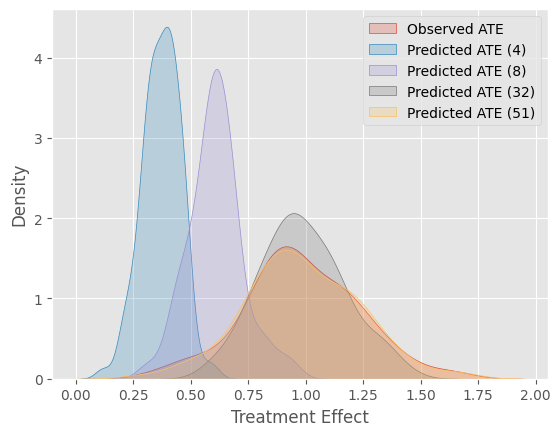

In [5]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
for n_surrogates in n_surrogate_list:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = True)

ax.legend()
ax.set_xlabel('Treatment Effect')